# Mini Resnet using Tensorflow Functional API 
@rajeev

* Build Model
* Download CIFAR 10 image data and pre-process 
* Compile Model
    * Setup Tensorboard callback
    * Setup Checkpoints callback
* Train the model
* Evaluate accuracy
* Inference
* View weights and bias

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.0


## Build model

In [2]:
inputs = tf.keras.Input(shape=(32,32,3))

x = tf.keras.layers.Conv2D(filters=32, kernel_size=3,activation='swish')(inputs)
# input  shape: 32, 32, 3
# output shape: 30, 30, 32
# parameters: weights=(3*3*3)*32 , biases=32

x = tf.keras.layers.Conv2D(filters=64, kernel_size=3,activation='swish')(x)
# input  shape: 30, 30, 32
# output shape: 28, 28, 64
# parameters: weights=(3*3*32)*64 , biases=64

stage1 = tf.keras.layers.MaxPooling2D(pool_size=3)(x)
# input  shape: 28, 28, 64
# output shape: (28-3/3)+1, (28-3/3)+1, 64 = 9, 9, 64


x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same',activation='relu')(stage1)
# input  shape: 9, 9, 64
# output shape: 9, 9, 64
# parameters: weights=(3*3*64)*64 , biases=64

x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same',activation='relu')(x)
# input  shape: 9, 9, 64
# output shape: 9, 9, 64
# parameters: weights=(3*3*64)*64 , biases=64

stage2 = tf.keras.layers.Add()([x, stage1])
# input  shape: 9, 9, 64
# output shape: 9, 9, 64


x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same',activation='relu')(stage2)
# input  shape: 9, 9, 64
# output shape: 9, 9, 64
# parameters: weights=(3*3*64)*64 , biases=64

x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same',activation='relu')(x)
# input  shape: 9, 9, 64
# output shape: 9, 9, 64
# parameters: weights=(3*3*64)*64 , biases=64

stage3 = tf.keras.layers.Add()([x, stage2])
# input  shape: 9, 9, 64
# output shape: 9, 9, 64


x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu')(stage3)
# input  shape: 9, 9, 64
# output shape: 7, 7, 64
# parameters: weights=(3*3*64)*64 , biases=64

x = tf.keras.layers.GlobalAveragePooling2D()(x)
#print("Global Average Pooling output shape: ", x.shape)
# input  shape: 7, 7, 64
# output shape: , 64

x = tf.keras.layers.Dense(256, activation="relu")(x)
#print("Global Average Pooling output shape: ", x.shape)
# input  shape: , 64
# output shape: , 256
# parameters = W.X + B : weights = (256,64), biases=256

x = tf.keras.layers.Dropout(0.5)(x)
# input  shape: , 256
# output shape: , 256

outputs = tf.keras.layers.Dense(10)(x)
# input  shape: , 256
# output shape: , 10
# parameters = W.X + B : weights = (10,256), biases=10


In [3]:
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="mini_resnet")
model.summary()

Model: "mini_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 30, 30, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 9, 9, 64)     0           conv2d_1[0][0]                   
________________________________________________________________________________________

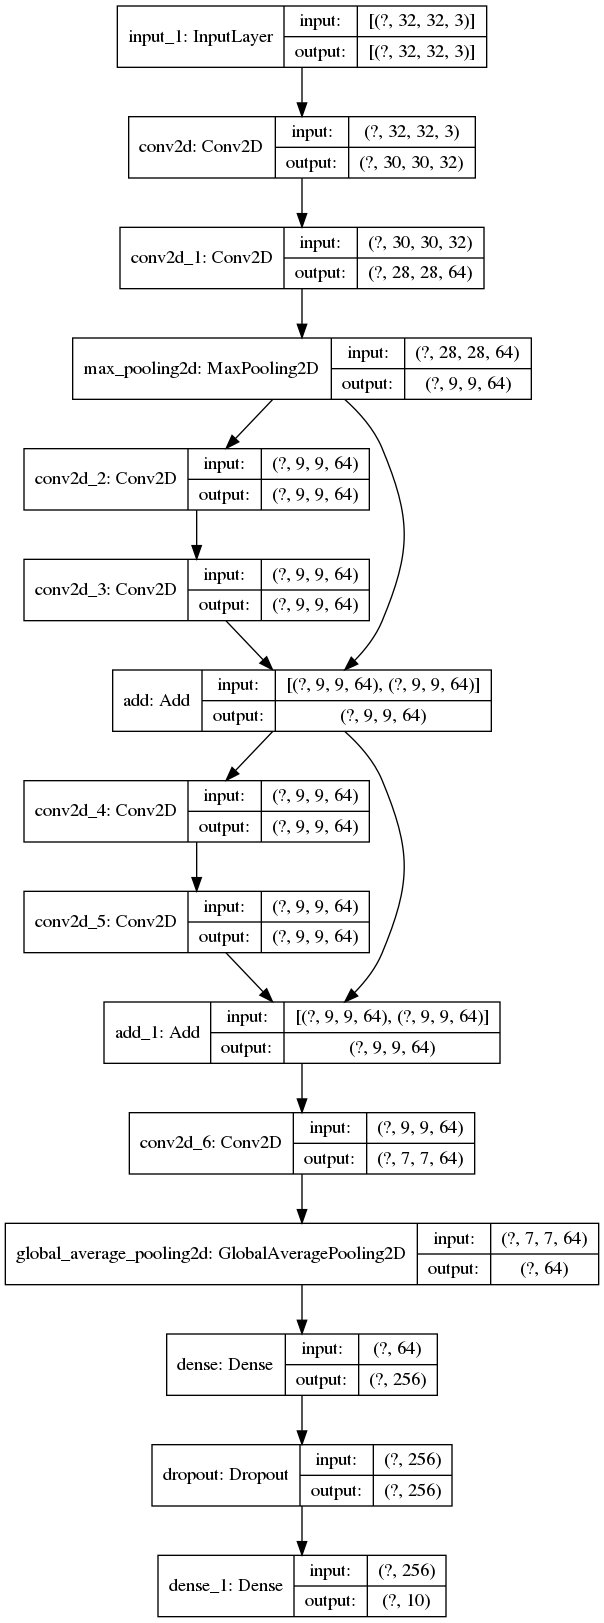

In [4]:
tf.keras.utils.plot_model(model, "model.png", show_shapes=True)

## Download CIFAR10 image dataset and pre-process 

In [5]:
cifar10 = tf.keras.datasets.cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(train_labels.shape, train_images.shape)

(50000, 1) (50000, 32, 32, 3)


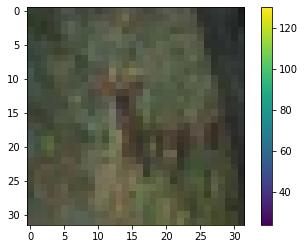

(32, 32, 3) [4]


In [6]:
i=10
plt.figure()
plt.imshow(train_images[i])
plt.colorbar()
plt.grid(False)
plt.show()
print(train_images[i].shape, train_labels[i])

In [7]:
train_images = train_images.astype('float32') / 255.0
test_images  = test_images.astype('float32') / 255.0
print(train_labels.shape, train_labels[0])

train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels  = tf.keras.utils.to_categorical(test_labels, 10)
print(train_labels[0])

(50000, 1) [6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


## Compile the model

In [8]:
model.compile(optimizer= tf.keras.optimizers.RMSprop(1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Setup Tensorboard callback

In [9]:
import tensorboard
import os
from datetime import datetime
print(tensorboard.__version__)
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, 
                                                      write_images=True, 
                                                      histogram_freq=1,
                                                     )

2.3.0


### Setup Checkpoints callback

In [10]:
# save checkpoints
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
model.save("/tmp/model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/model/assets


## Train the Model

In [11]:
model.fit(train_images, train_labels, epochs=10, batch_size=32, callbacks=[tensorboard_callback, cp_callback])

Epoch 1/10
   1/1563 [..............................] - ETA: 0s - loss: 2.2965 - accuracy: 0.1250WARNING:tensorflow:From /home/raj/anaconda3/envs/rdn/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1563/1563 [==============================] - ETA: 0s - loss: 1.6524 - accuracy: 0.3846
Epoch 00001: saving model to training_1/cp.ckpt
1563/1563 [==============================] - 72s 46ms/step - loss: 1.6524 - accuracy: 0.3846
Epoch 2/10
1563/1563 [==============================] - ETA: 0s - loss: 1.1728 - accuracy: 0.5836
Epoch 00002: saving model to training_1/cp.ckpt
1563/1563 [==============================] - 72s 46ms/step - loss: 1.1728 - accuracy: 0.5836
Epoch 3/10
1563/1563 [==============================] - ETA: 0s - loss: 0.9728 - accuracy: 0.6635
Epoch 00003: saving model to training_1/cp

## Evaluate accuracy

In [12]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 3s - loss: 1.0873 - accuracy: 0.6839

Test accuracy: 0.683899998664856


## Inference

In [13]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_images)
print(predictions[0])
nn = test_labels[np.argmax(predictions[0])]
print(nn)

[0.20984985 0.06065569 0.0378563  0.14592914 0.04657747 0.04840575
 0.07721744 0.02575805 0.21712193 0.13062844]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


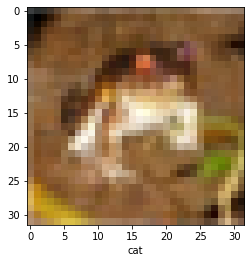

In [14]:
idx, = np.where(nn==1.0)
plt.figure(2)
plt.imshow(train_images[0], cmap=plt.cm.binary)
plt.xlabel(class_names[int(idx)])
plt.show()

## View weights and biases

In [15]:
model.layers

In [16]:
weights, biases = model.layers[4].get_weights()

In [17]:
print(weights.shape, biases.shape)

(3, 3, 64, 64) (64,)


In [18]:
print ("Biases : ", biases)

Biases :  [ 1.64491702e-02 -9.36663225e-02 -3.85572985e-02 -4.14497368e-02
  2.54953955e-03 -1.46986973e-02 -3.29788029e-02 -3.24437618e-02
 -5.26996702e-02  3.39350551e-02 -4.59332876e-02 -4.57153842e-02
 -4.69489135e-02 -1.10341340e-01 -4.75009158e-02 -2.36282572e-02
 -4.92194258e-02 -9.57483053e-03 -1.09840125e-01 -8.96951929e-03
 -8.75428468e-02 -6.74951226e-02 -3.55090350e-02 -7.06310570e-02
 -5.05694002e-02  4.61232029e-02  3.74118686e-02  3.59124970e-05
 -1.01441219e-02 -2.22996697e-02  7.74990860e-03 -2.24263724e-02
 -5.17760366e-02 -5.39129376e-02 -6.82524145e-02 -7.31149316e-03
 -6.27481192e-02 -2.90767197e-02  5.03726713e-02 -5.60981035e-02
 -1.20032830e-02 -5.25045022e-02 -2.15780269e-02 -4.88698967e-02
  3.63829732e-03 -4.57391515e-02 -5.98628335e-02  2.01858506e-02
 -3.62880784e-03 -1.41149238e-01 -3.04413936e-03 -3.77854635e-03
 -8.08941433e-04 -8.28746483e-02 -2.13772934e-02 -6.72124550e-02
 -1.36583140e-02 -1.64685711e-01 -2.39980929e-02 -7.14096874e-02
  1.88289918e-0